In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.TwitterDataCleaned
DATASET_NAME = 'TwitterData'
MODEL_NAME = 'Bert'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
EPOCHS = 6
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}


# Cross Validation
we try to get the best parameters for a bert model on the datacleanedTwitter dataset

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-04,1e-05],
    'regularization': [0, 1e-05],
    'batch_size': [8, 16],
    'epochs': [EPOCHS],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Bert, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_dow

In [5]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])
print(BEST_PARAMS)

BEST MODEL INFO
{'batch_size': 8.0, 'epochs': 6.0, 'learning_rate': 1e-05, 'n_classes': 6.0, 'regularization': 1e-05, 'train_accuracy': 0.94925, 'train_jaccard_macro': 0.8706956837799144, 'train_f1_macro': 0.9288996677224158, 'train_jaccard_samples': 0.95271875, 'train_f1_micro': 0.954318522216675, 'train_membership': 0.9548125, 'val_accuracy': 0.939, 'val_jaccard_macro': 0.8642597912167486, 'val_f1_macro': 0.9262144218233838, 'val_jaccard_samples': 0.94225, 'val_f1_micro': 0.9437314906219151, 'val_membership': 0.944}
RESULTS
    batch_size  epochs  learning_rate  n_classes  regularization  \
0            8       1        0.00005          6         0.00000   
1            8       6        0.00005          6         0.00000   
2           16       6        0.00005          6         0.00000   
3            8       6        0.00005          6         0.00001   
4           16       6        0.00005          6         0.00001   
5            8       6        0.00010          6         0.0

In [6]:
MINIBATCH_SIZE = 8
EPOCHS = 6
LAMBDA = 1e-05
LEARNING_RATE = 1e-05
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}
#  create the model with the best parameters
model = Bert(SCORES, BEST_PARAMS)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

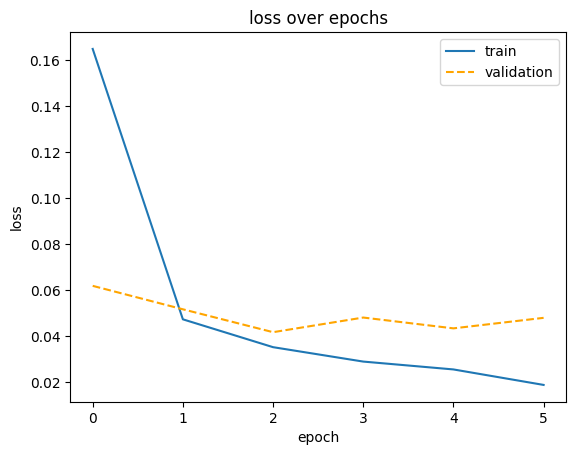

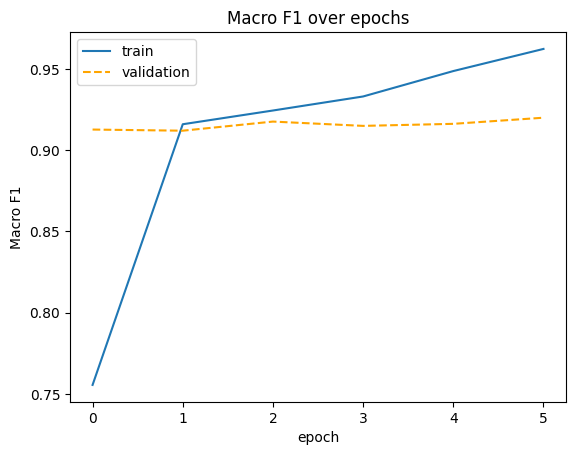

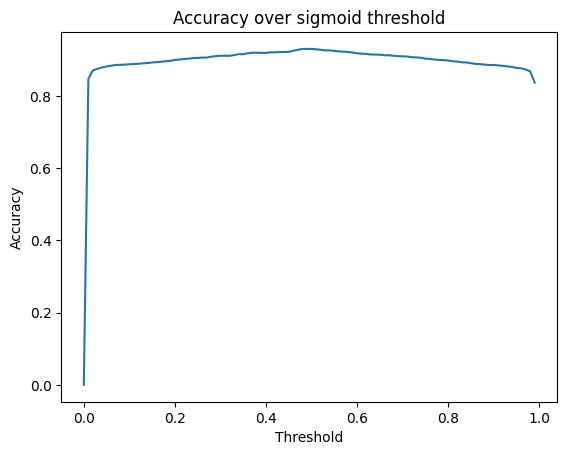

Best threshold: 0.48
Best Accuracy: 0.9305


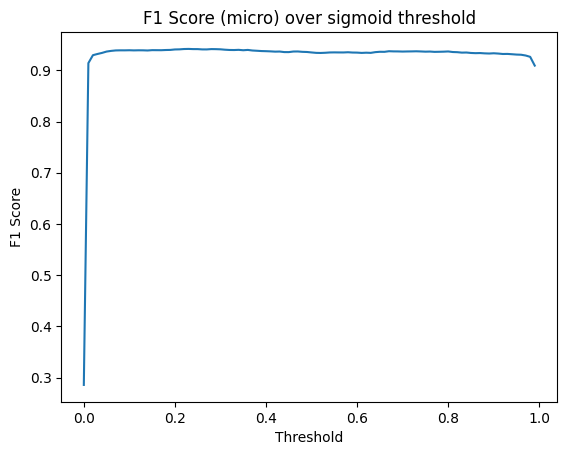

Best threshold: 0.23
Best F1 Score (micro): 0.9418576598311218


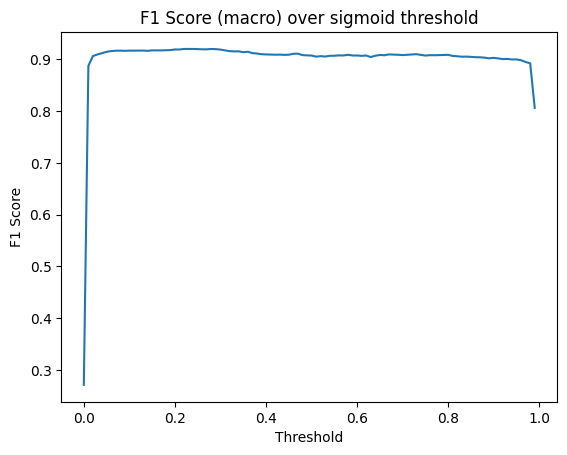

Best threshold: 0.23
Best F1 Score (macro): 0.9199278989226537


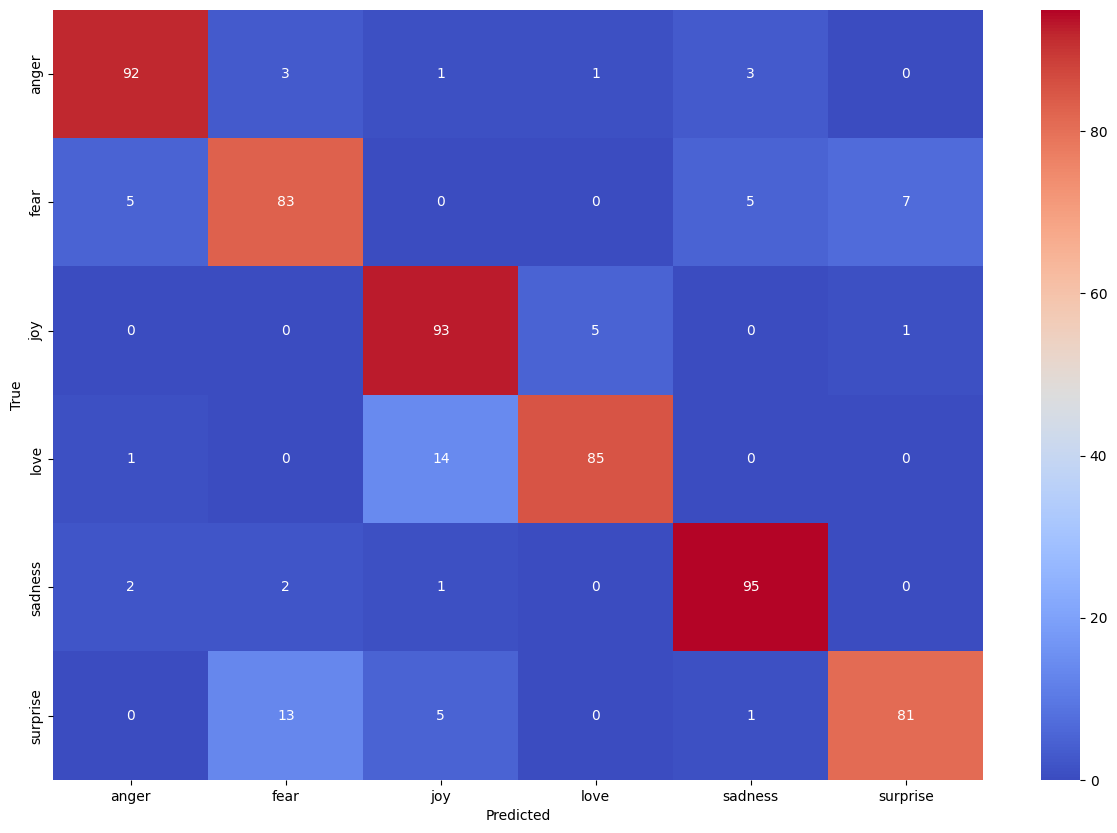

              precision    recall  f1-score   support

       anger       0.90      0.97      0.94       275
        fear       0.85      0.97      0.91       212
         joy       0.95      0.98      0.96       704
        love       0.81      0.97      0.88       178
     sadness       0.96      0.98      0.97       550
    surprise       0.77      0.99      0.86        81

   micro avg       0.91      0.98      0.94      2000
   macro avg       0.87      0.98      0.92      2000
weighted avg       0.91      0.98      0.94      2000
 samples avg       0.94      0.98      0.95      2000

Jaccard Samples Score: 0.93975
Jaccard Macro Score: 0.854056889073923
Membership Score: 0.9355


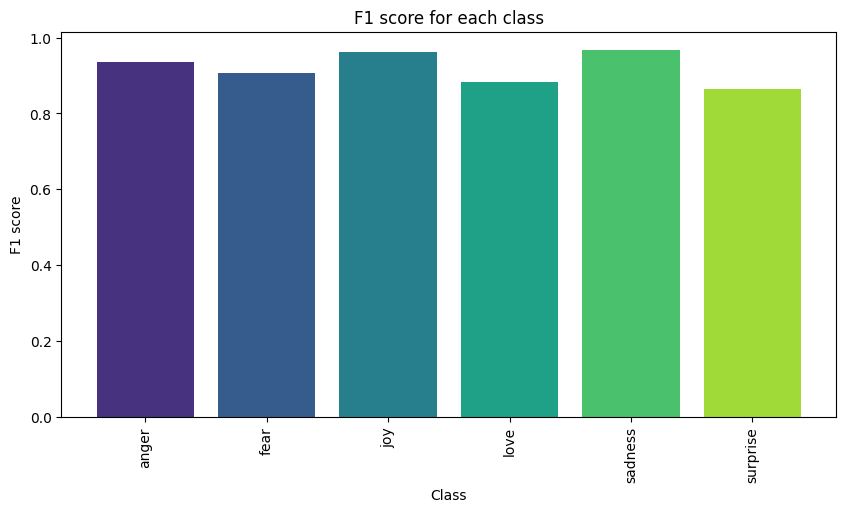

In [8]:
twitter_model_analysis(model, val_df, LABEL_COLS)

Now we can train a bert model with the best parameter and a fixed seed to reproduce the result and compare it with the uncleaned dataset

In [4]:
MINIBATCH_SIZE = 8
EPOCHS = 4
LAMBDA = 1e-05
LEARNING_RATE = 1e-05
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterDataCleaned)
MODEL_NAME = 'BertCleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}


SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}
seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Bert(SCORES,
                PARAMS)    
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)

out_cleaned = model.predict(val_df)
target_cleaned = val_df.iloc[:, 1:].values
best_out_cleaned = np.argmax(out_cleaned, axis=1)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Threshold = 0.08


## Twitter:NoDataCleaning
We try to validate our datacleaning process training a bert model with vanilla tr-set

In [4]:
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)
MODEL_NAME = 'BertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
MINIBATCH_SIZE = 8
EPOCHS = 4
LAMBDA = 1e-05
LEARNING_RATE = 1e-05
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}

SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}

# creating the model with the same seed as the cleaned version
seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_uncleaned = Bert(SCORES,
                PARAMS)    
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)
out_uncleaned = model_uncleaned.predict(val_df)
target_uncleaned = val_df.iloc[:, 1:].values
best_out_uncleaned = np.argmax(out_uncleaned, axis=1)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Threshold = 0.48


In [ ]:
twitter_model_analysis(model_uncleaned, val_df, LABEL_COLS)

In [5]:
_,val_df_uncleaned,_ = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)
_,val_df,_ = load_dataset(DatasetEnum.TwitterDataCleaned)
MODEL_NAME = 'BertCleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_cleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)
MODEL_NAME = 'BertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_uncleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)

thresh_cleaned=0.08
thresh_uncleaned=0.48

out_uncleaned = model_uncleaned.predict(val_df_uncleaned)
best_out_uncleaned = np.argmax(out_uncleaned, axis=1)
   
out_cleaned = model_cleaned.predict(val_df)
best_out_cleaned = np.argmax(out_cleaned, axis=1)


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now we can compare the graphical results of the obtained models

C:\Users\gdema\AppData\Local\Temp\ipykernel_5196\2501826934.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


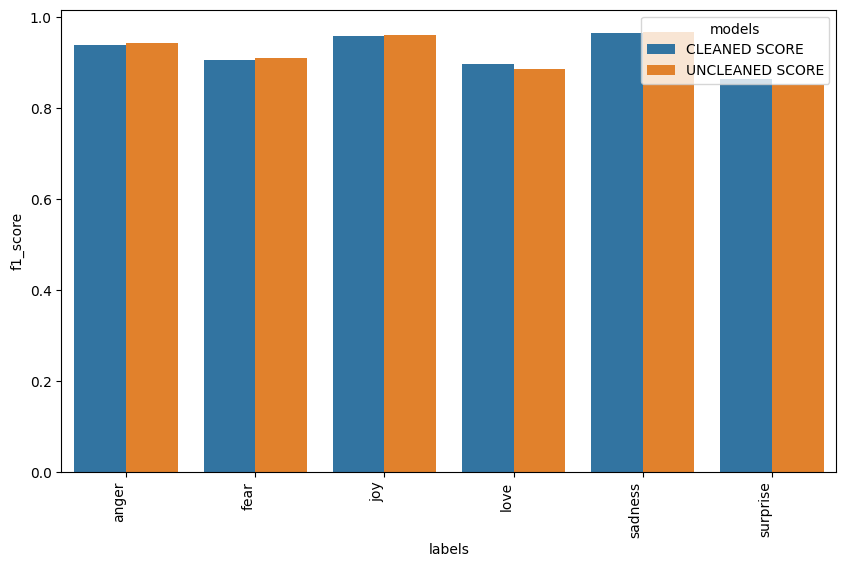

cleaned mean = 0.9221390418072893
uncleaned mean = 0.9206735532552778


In [6]:

cleaned_score = f1_score(target_cleaned, best_out_cleaned,average=None)
uncleaned_score = f1_score(target_uncleaned, best_out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")